Install Packages/Libraries

In [1]:
%pip install --upgrade pip
%pip install torch torchaudio
%pip install torchvision --index-url https://download.pytorch.org/whl/cu124

%pip install pandas
%pip install datasets
%pip install peft
%pip install transformers
%pip install transformers[torch]
%pip install 'accelerate>=0.26.0'

%pip install matplotlib

%pip install evaluate
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparselt_cu12-0.6.2-py3-none-manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014

Import Packages/Libraries

In [2]:
import os, re, glob,math, torch, time, evaluate, pandas as pd, matplotlib.pyplot as plt, numpy as np
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import (
    GPT2TokenizerFast,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer, TrainingArguments, TrainerCallback
)
from peft import get_peft_model, LoraConfig, TaskType

Configurations

In [3]:
USE_LORA                    = True
DATA_DIR                    = "outputs/bigcode-ts-output-50000-formatted"
METADATA_CSV                = "outputs/bigcode-ts-output-50000-types.csv"
OUTPUT_DIR                  = "outputs/typescriptmate-50000-lora"
BATCH_SIZE                  = 4
MAX_LENGTH                  = 512
EPOCHS                      = 5
LR                          = 5e-5
GRAD_CLIP                   = 0.0
SEED                        = 42
WEIGHT_DECAY                = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

Count number of TypeScipt files in folder

In [4]:
file_count = sum(len(files) for _, _, files in os.walk(DATA_DIR))
print("Total files:", file_count)

Total files: 46065


Check if MPS (Accelerated PyTorch Training for Apple Silicon) is supported

In [5]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())


False
False


Load metadata for Type Awareness

In [6]:
df = pd.read_csv(METADATA_CSV)
metadata_cols = [
    "Interfaces", "TypeAliases", "Enums",
    "Classes", "Decorators", "Imports",
    "Exports", "PredefinedTypesUsed"
]
for col in metadata_cols:
    if col in df.columns:
        df[col] = df[col].fillna("")
print(f"Loaded {len(df)} metadata rows")

Loaded 46024 metadata rows


Attach file text

In [7]:
dataset_meta = Dataset.from_pandas(df, preserve_index=False)

def add_text_and_metadata(example):
    path = example["File"]
    if not os.path.isabs(path):
        path = os.path.join(DATA_DIR, path)

    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            example["text"] = f.read()
    except FileNotFoundError:
        example["text"] = ""

    example["interfaces"] = example.get("Interfaces", "")
    example["type_aliases"] = example.get("TypeAliases", "")
    example["enums"] = example.get("Enums", "")
    example["classes"] = example.get("Classes", "")
    example["decorators"] = example.get("Decorators", "")
    example["imports"] = example.get("Imports", "")
    example["exports"] = example.get("Exports", "")
    example["predefined_types"] = example.get("PredefinedTypesUsed", "")
    return example

dataset_meta = dataset_meta.map(add_text_and_metadata, batched=False)
print(dataset_meta)

Map:   0%|          | 0/46024 [00:00<?, ? examples/s]

Dataset({
    features: ['File', 'Interfaces', 'TypeAliases', 'Enums', 'Classes', 'Decorators', 'Imports', 'Exports', 'PredefinedTypesUsed', 'text', 'interfaces', 'type_aliases', 'enums', 'classes', 'decorators', 'imports', 'exports', 'predefined_types'],
    num_rows: 46024
})


Filter bad examples

In [8]:
dataset_meta = dataset_meta.filter(lambda ex: ex["text"].strip() != "")
print("Non-empty examples:", len(dataset_meta))

Filter:   0%|          | 0/46024 [00:00<?, ? examples/s]

Non-empty examples: 46024


Split and filter train and validation data for annotated examples

In [9]:
splits = dataset_meta.train_test_split(test_size=0.1, seed=SEED)
datasets = DatasetDict({
    "train": splits["train"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"]),
    "validation": splits["test"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"])
})
print("Filtered split:")
print("  • train:", len(datasets["train"]))
print("  • validation:", len(datasets["validation"]))

Filter:   0%|          | 0/41421 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4603 [00:00<?, ? examples/s]

Filtered split:
  • train: 6416
  • validation: 751


Tokenize

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_attention_mask=True,
    )

tokenized = datasets.map(
    tokenize_fn,
    batched=True,
    remove_columns=datasets["train"].column_names
)

Map:   0%|          | 0/6416 [00:00<?, ? examples/s]

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

Sanity check on tokens

In [11]:
valid_count = sum(
    any(tok != tokenizer.eos_token_id for tok in ex["input_ids"])
    for ex in tokenized["train"]
)
print(f"Usable tokenized examples: {valid_count} / {len(tokenized['train'])}")

Usable tokenized examples: 6416 / 6416


Collator & base Model

In [12]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=None,
)
base_model = AutoModelForCausalLM.from_pretrained("gpt2")
base_model.config.pad_token_id = base_model.config.eos_token_id

Apply LoRA if enabled

In [13]:
if USE_LORA:
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=338,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        target_modules=["c_attn", "q_attn", "v_attn"]
    )
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
else:
    model = base_model

trainable params: 12,460,032 || all params: 136,899,840 || trainable%: 9.1016


/opt/conda/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Move model to supported device

In [14]:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

model.to(device)

Using device: cuda


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=2304, nx=768)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=338, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=338, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
      

TrainingArguments

In [15]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, 
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY, 
    max_grad_norm=GRAD_CLIP,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    logging_strategy="steps",
    eval_strategy="steps",
    save_strategy="steps",
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    push_to_hub=True,
)

Trainer with loss logger

In [16]:
class LossLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        print("LOGS:", logs)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
    callbacks=[LossLogger()]
)

Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training

In [17]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,2.317700,2.078392
1000,2.184100,1.988864
1500,2.077500,1.949540
2000,2.137700,1.925503
2500,2.078500,1.909229
3000,2.061300,1.900025
3500,2.062100,1.894390
4000,2.054900,1.892396


LOGS: {'loss': 2.9256, 'learning_rate': 4.876558603491272e-05, 'epoch': 0.12468827930174564}
LOGS: {'loss': 2.6325, 'learning_rate': 4.751870324189526e-05, 'epoch': 0.24937655860349128}
LOGS: {'loss': 2.4862, 'learning_rate': 4.627182044887781e-05, 'epoch': 0.3740648379052369}
LOGS: {'loss': 2.3792, 'learning_rate': 4.5024937655860346e-05, 'epoch': 0.49875311720698257}
LOGS: {'loss': 2.3177, 'learning_rate': 4.377805486284289e-05, 'epoch': 0.6234413965087282}
LOGS: {'eval_loss': 2.0783920288085938, 'eval_runtime': 14.1593, 'eval_samples_per_second': 53.039, 'eval_steps_per_second': 13.278, 'epoch': 0.6234413965087282}
LOGS: {'loss': 2.2772, 'learning_rate': 4.253117206982544e-05, 'epoch': 0.7481296758104738}
LOGS: {'loss': 2.2159, 'learning_rate': 4.128428927680798e-05, 'epoch': 0.8728179551122195}
LOGS: {'loss': 2.2009, 'learning_rate': 4.0037406483790525e-05, 'epoch': 0.9975062344139651}
LOGS: {'loss': 2.2381, 'learning_rate': 3.8790523690773065e-05, 'epoch': 1.1221945137157108}
LOGS

TrainOutput(global_step=4010, training_loss=2.162428993833927, metrics={'train_runtime': 1553.0397, 'train_samples_per_second': 20.656, 'train_steps_per_second': 2.582, 'total_flos': 9610181549752320.0, 'train_loss': 2.162428993833927, 'epoch': 5.0})

Save model, tokenizer and deploy

In [18]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
trainer.save_model(OUTPUT_DIR)

Basic evaluation

In [19]:
eval_results = trainer.evaluate()

print("Full eval results:", eval_results)

if eval_results.get("eval_loss") is not None and not math.isnan(eval_results["eval_loss"]):
    print("Validation Perplexity: ", math.exp(eval_results["eval_loss"]))
else:
    print("NaN eval loss")

LOGS: {'eval_loss': 1.8923957347869873, 'eval_runtime': 14.1891, 'eval_samples_per_second': 52.928, 'eval_steps_per_second': 13.25, 'epoch': 5.0}
Full eval results: {'eval_loss': 1.8923957347869873, 'eval_runtime': 14.1891, 'eval_samples_per_second': 52.928, 'eval_steps_per_second': 13.25, 'epoch': 5.0}
Validation Perplexity:  6.6352459441218645


Convert the trainer log history into a DataFrame

In [20]:
logs = trainer.state.log_history
df = pd.DataFrame(logs)
print(df)

      loss  learning_rate     epoch  step  eval_loss  eval_runtime  \
0   2.9256   4.876559e-05  0.124688   100        NaN           NaN   
1   2.6325   4.751870e-05  0.249377   200        NaN           NaN   
2   2.4862   4.627182e-05  0.374065   300        NaN           NaN   
3   2.3792   4.502494e-05  0.498753   400        NaN           NaN   
4   2.3177   4.377805e-05  0.623441   500        NaN           NaN   
5      NaN            NaN  0.623441   500   2.078392       14.1593   
6   2.2772   4.253117e-05  0.748130   600        NaN           NaN   
7   2.2159   4.128429e-05  0.872818   700        NaN           NaN   
8   2.2009   4.003741e-05  0.997506   800        NaN           NaN   
9   2.2381   3.879052e-05  1.122195   900        NaN           NaN   
10  2.1841   3.754364e-05  1.246883  1000        NaN           NaN   
11     NaN            NaN  1.246883  1000   1.988864       14.2794   
12  2.1681   3.629676e-05  1.371571  1100        NaN           NaN   
13  2.1666   3.50498

Plot training loss vs global step

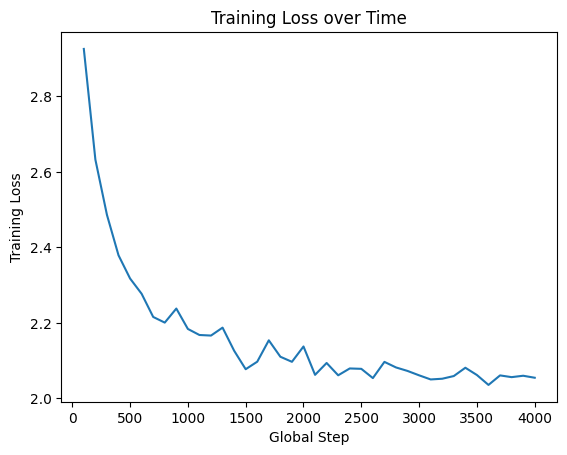

In [21]:
train_df = df[df["loss"].notna()]
plt.plot(train_df["step"], train_df["loss"])
plt.xlabel("Global Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Time")
plt.show()

Plot training perplexity vs global step

/tmp/ipykernel_14955/702312287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["perplexity"] = train_df["loss"].apply(math.exp)


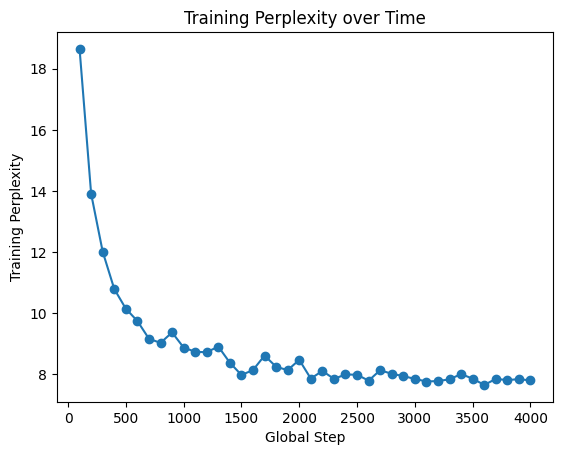

In [22]:
train_df["perplexity"] = train_df["loss"].apply(math.exp)
plt.figure()
plt.plot(train_df["step"], train_df["perplexity"], marker="o")
plt.xlabel("Global Step")
plt.ylabel("Training Perplexity")
plt.title("Training Perplexity over Time")
plt.show()

Load each checkpoint’s weights into your model

In [23]:
ckpt_paths = glob.glob(os.path.join(OUTPUT_DIR, "checkpoint-*"))

ckpt_paths = sorted(
    ckpt_paths,
    key=lambda p: int(re.search(r"checkpoint-(\d+)$", p).group(1))
)

print(ckpt_paths)

records = []
for ckpt_path in ckpt_paths:
    # 1) Reload the model weights
    model = AutoModelForCausalLM.from_pretrained(ckpt_path)
    model.to(trainer.args.device)

    # 2) Patch the Trainer’s model
    trainer.model = model

    # 3) Run evaluation on your validation split
    metrics = trainer.evaluate()        # no args here

    # 4) Record step & loss (& perplexity)
    step = int(ckpt_path.split("-")[-1])
    loss = metrics["eval_loss"]
    records.append({
      "step": step,
      "eval_loss": loss,
      "perplexity": math.exp(loss)
    })

df = pd.DataFrame(records).sort_values("step")

['outputs/typescriptmate-50000-lora/checkpoint-500', 'outputs/typescriptmate-50000-lora/checkpoint-1000', 'outputs/typescriptmate-50000-lora/checkpoint-1500', 'outputs/typescriptmate-50000-lora/checkpoint-2000', 'outputs/typescriptmate-50000-lora/checkpoint-2500', 'outputs/typescriptmate-50000-lora/checkpoint-3000', 'outputs/typescriptmate-50000-lora/checkpoint-3500', 'outputs/typescriptmate-50000-lora/checkpoint-4000', 'outputs/typescriptmate-50000-lora/checkpoint-4010']
LOGS: {'eval_loss': 2.0783920288085938, 'eval_runtime': 14.1951, 'eval_samples_per_second': 52.905, 'eval_steps_per_second': 13.244, 'epoch': 5.0}
LOGS: {'eval_loss': 1.9888644218444824, 'eval_runtime': 14.2241, 'eval_samples_per_second': 52.798, 'eval_steps_per_second': 13.217, 'epoch': 5.0}
LOGS: {'eval_loss': 1.9495402574539185, 'eval_runtime': 14.2295, 'eval_samples_per_second': 52.778, 'eval_steps_per_second': 13.212, 'epoch': 5.0}
LOGS: {'eval_loss': 1.9255032539367676, 'eval_runtime': 14.222, 'eval_samples_per_

Plot evaluation loss vs global step

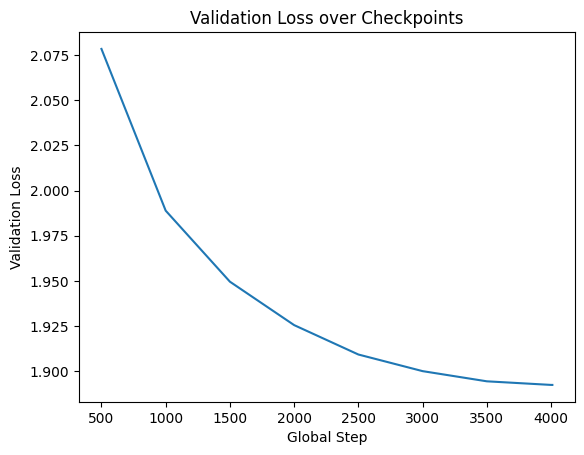

In [24]:
plt.figure()
plt.plot(df["step"], df["eval_loss"])
plt.xlabel("Global Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Checkpoints")
plt.show()

Convert loss to perplexity for easier interpretation: perplexity = exp(loss)

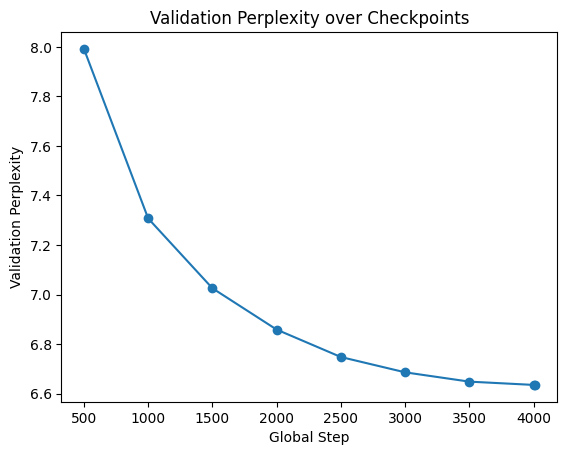

In [25]:
plt.figure()
plt.plot(df["step"], df["perplexity"], marker="o")
plt.xlabel("Global Step")
plt.ylabel("Validation Perplexity")
plt.title("Validation Perplexity over Checkpoints")
plt.show()

Top-5 Token Accuracy and MRR over validation set

In [26]:
def stream_topk_mrr(model, trainer, k=5, batch_size=1):
    """
    Streams through the Trainer’s eval_dataloader batch-by-batch,
    accumulates top-k matches and reciprocal ranks,
    and keeps memory use small.
    """
    # Put model in eval mode & grab device
    model.eval()
    device = next(model.parameters()).device
    
    # Use the Trainer’s built-in eval dataloader (with correct collation)
    loader: DataLoader = trainer.get_eval_dataloader()
    
    total_tokens = 0
    topk_matches = 0
    rr_sum = 0.0

    with torch.no_grad():
        for batch in loader:
            # batch is a dict of torch.Tensor already
            labels = batch.pop("labels").to(device)   # shape (bs, seq_len)
            # move all other inputs to device
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            # forward
            logits = model(**inputs).logits.cpu().numpy()  # (bs, seq_len, vocab_size)
            lbls   = labels.cpu().numpy()                 # (bs, seq_len)

            # mask out padding tokens
            mask = lbls != -100                             # (bs, seq_len)
            flat_logits = logits[mask].reshape(-1, logits.shape[-1])  # (N_toks, V)
            flat_labels = lbls[mask].reshape(-1)                     # (N_toks,)

            # Top-k matches via argpartition (cheap per-row)
            topk_idxs = np.argpartition(flat_logits, -k, axis=-1)[:, -k:]
            topk_matches += np.sum([flat_labels[i] in topk_idxs[i]
                                    for i in range(flat_labels.shape[0])])

            # MRR: rank = 1 + # of logits > true_logit
            true_scores = flat_logits[np.arange(flat_labels.shape[0]), flat_labels]
            ranks = 1 + np.sum(flat_logits > true_scores[:, None], axis=1)
            rr_sum += np.sum(1.0 / ranks)

            total_tokens += flat_labels.shape[0]

    topk_acc = topk_matches / total_tokens
    mrr      = rr_sum / total_tokens
    return topk_acc, mrr

# Usage:
top5_acc, mrr = stream_topk_mrr(model, trainer, k=5)
print(f"Top-5 Accuracy: {top5_acc:.4f}")
print(f"MRR:             {mrr:.4f}")


Top-5 Accuracy: 0.1958
MRR:             0.1674


Top-5 Accuracy bar chart

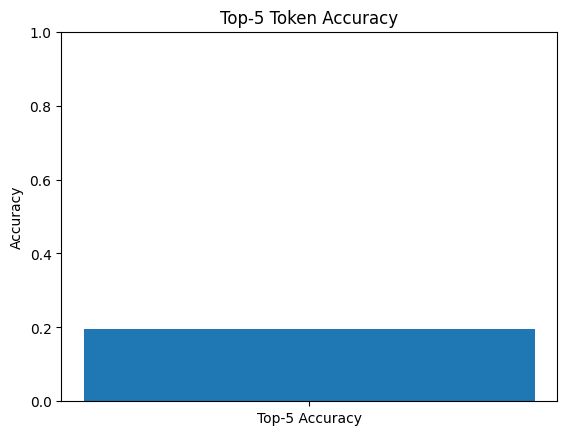

In [27]:
plt.figure()
plt.bar(['Top-5 Accuracy'], [top5_acc])
plt.ylim(0, 1)
plt.title('Top-5 Token Accuracy')
plt.ylabel('Accuracy')
plt.show()

MRR bar chart

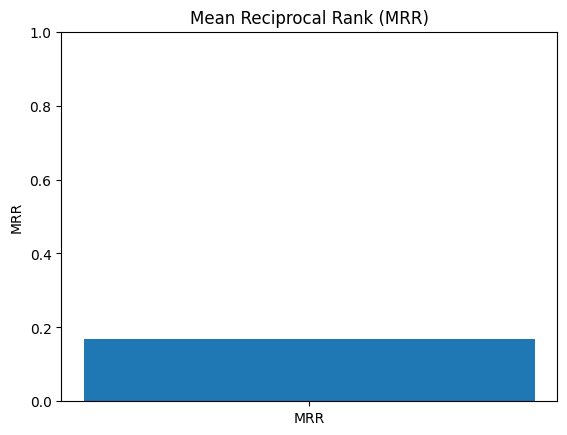

In [28]:
plt.figure()
plt.bar(['MRR'], [mrr])
plt.ylim(0, 1)
plt.title('Mean Reciprocal Rank (MRR)')
plt.ylabel('MRR')
plt.show()

Inference Latency Histogram
Measure per-sample inference latency and visualize

Mean latency: 0.0079s
Std  latency: 0.0002s


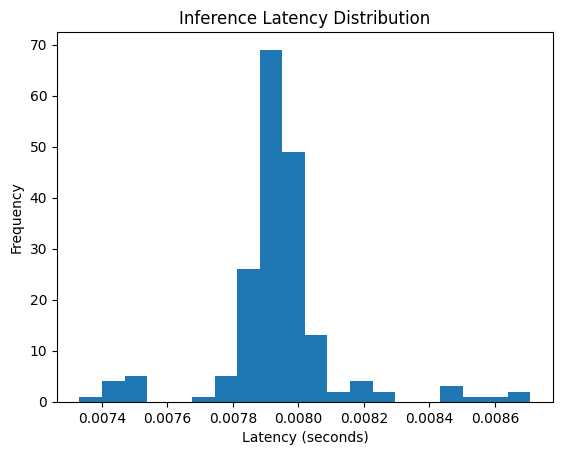

In [29]:
model.eval()
device = next(model.parameters()).device
loader = trainer.get_eval_dataloader()

latencies = []
with torch.no_grad():
    for batch in loader:
        batch.pop("labels", None)
        inputs = {k: v.to(device) for k, v in batch.items()}
        start = time.monotonic()
        _ = model(**inputs)
        end = time.monotonic()
        latencies.append(end - start)

latencies = np.array(latencies)

print(f"Mean latency: {latencies.mean():.4f}s")
print(f"Std  latency: {latencies.std():.4f}s")

plt.figure()
plt.hist(latencies, bins=20)
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Inference Latency Distribution")
plt.show()
